In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import xgboost as xgb
import sklearn.model_selection as model_selection
from xgboost import XGBRegressor, plot_importance 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [3]:
# flights table
data = pd.read_csv('/Users/Matthew Wong/flights_table_optimized(50,000 points).csv',delimiter=';')
data = data.iloc[: , 1:]
display(data.head())
display(data.shape)

,month,day,year,origin_city,origin_city_state,dest_city,dest_city_state,Route,distance,air_time,...,taxi_in_route,dep_delay_city,arr_delay_city,taxi_out_city,taxi_in_city,dep_delay_month,arr_delay_month,taxi_out_month,taxi_in_month,arr_delay
0,12,30,2019,220,17,105,8,2987,674.0,84.0,...,8.444444,1.710611,-4.176849,11.800643,8.057878,0.892546,-5.488575,17.429543,7.718988,-3.0
1,4,8,2018,296,49,233,4,4370,672.0,98.0,...,6.208333,1.014692,-4.634527,19.509642,6.965106,-0.045202,-5.727201,16.802538,7.431139,25.0
2,11,21,2018,52,40,17,9,604,259.0,46.0,...,10.238095,-1.163522,-7.421384,14.861635,8.779874,0.093850,-5.732620,16.940107,7.404545,-13.0
3,12,19,2019,103,8,249,37,1730,994.0,128.0,...,5.333333,1.163701,-4.740214,17.135231,7.814947,0.892546,-5.488575,17.429543,7.718988,-16.0
4,9,21,2019,267,46,61,13,3848,530.0,82.0,...,10.666667,1.934783,-4.913043,18.152174,8.673913,-0.826970,-6.525318,16.681560,7.540753,-36.0


(44551, 24)

In [4]:
#Assign train and target variables
X = data[['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance','air_time','depart_hour','dep_delay_route','arr_delay_route','taxi_out_route','taxi_in_route','dep_delay_city','arr_delay_city','taxi_out_city','taxi_in_city','dep_delay_month','arr_delay_month','taxi_out_month','taxi_in_month']]
y = data['arr_delay']

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

In [9]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train, verbose=False)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)

Train r2 score:  -0.7138602689905806
Test r2 score:  0.1741794893439922
Train RMSE: 11.2720
Test RMSE: 14.2252


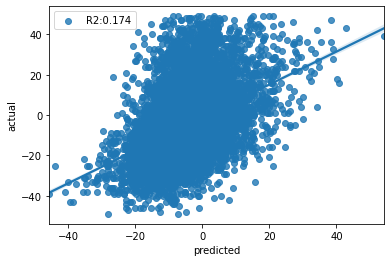

In [10]:
#prints the R2 score for your test dataset
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

# XGBoost Gridsearch

In [11]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [12]:
#define hyperparameters we want to tune
param_grid = {
        'min_child_weight': [5],
        'gamma': [5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

#instantiate GridSearchCV, fit model, and make prediction
model = GridSearchCV(estimator=xgb, param_grid = param_grid, cv = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

df = pd.DataFrame(model.cv_results_)

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Matthew Wong\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Matthew Wong\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:26:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:26:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Matthew Wong\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:49:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:49:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Matthew Wong\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:10:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:10:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Matthew Wong\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:31:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:31:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Matthew Wong\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:52:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [13]:
display(model.best_params_)
display(model.best_score_)

df.sort_values('rank_test_score', ascending = True).head(3)

{'colsample_bytree': 1.0,
 'gamma': 5,
 'max_depth': 5,
 'min_child_weight': 5,
 'subsample': 1.0}

0.03594416367717112

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1313.766562,65.349402,1.895831,0.213162,1,5,5,5,1,"{'colsample_bytree': 1.0, 'gamma': 5, 'max_dep...",0.033817,0.035014,0.03666,0.036965,0.037264,0.035944,0.001318,1
